In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv("crx.data")
df = df.sample(frac=1)

In [3]:
df.head()

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,y
52,b,37.42,2.04,u,g,w,v,0.040,t,f,0,t,g,00400,5800,+
64,b,26.67,4.25,u,g,cc,v,4.290,t,t,1,t,g,00120,0,+
398,b,26.17,12.50,y,p,k,h,1.250,f,f,0,t,g,00000,17,-
132,a,47.42,8.00,u,g,e,bb,6.500,t,t,6,f,g,00375,51100,+
442,b,30.58,2.71,y,p,m,v,0.125,f,f,0,t,s,00080,0,-


In [4]:
df.shape

(690, 16)

In [5]:
df['y'].value_counts()/df.shape[0]

-    0.555072
+    0.444928
Name: y, dtype: float64

Japanese Credit Screening dataset from UCI repo.<br>
From the dataset documentation: <br>
This file concerns credit card applications.  All attribute names and values have been changed to meaningless symbols to protect confidentiality of the data.<br>
This dataset is interesting because there is a good mix of attributes -- continuous, nominal with small numbers of values, and nominal with larger numbers of values.  There are also a few missing values.<br>
Missing Attribute Values: <br>
37 cases (5%) have one or more missing values.  The missing values from particular attributes are:<br>
A1:  12 <br> A2:  12 <br> A4:   6 <br> A5:   6 <br> A6:   9 <br> A7:   9 <br> A14: 13 <br>
<br>
Strategy for replacing missing:<br>
categorical - replace with mode: A1, A4, A5, A6, A7 <br>
numeric - replace mean: A2, A14

In [6]:
#replacing missing
for i in ['A2','A14']:
    idx = df[i].loc[df[i] == '?'].index
    m = df[i].drop(idx,axis=0).astype(float).mean()
    df[i] = df[i].replace('?',m).astype(float)

for i in ['A1','A4','A5','A6','A7']:
    df[i] = df[i].replace('?',df[i].mode()[0])

In [7]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = list(set(df.columns.tolist())-set(num_cols))
cat_cols.remove('y')

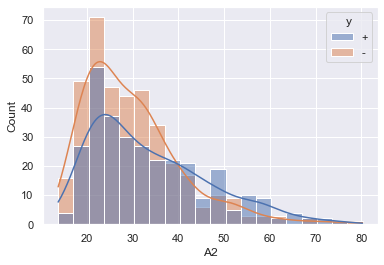

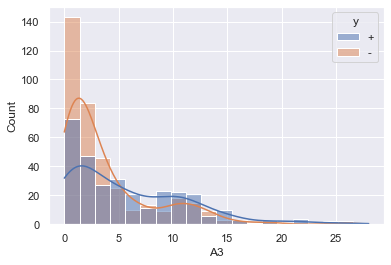

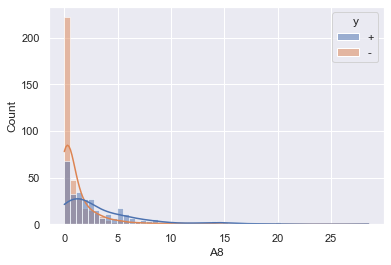

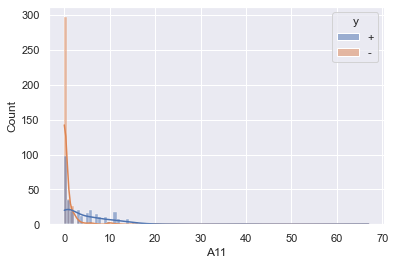

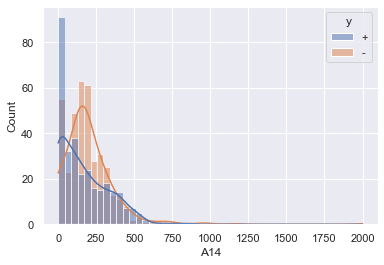

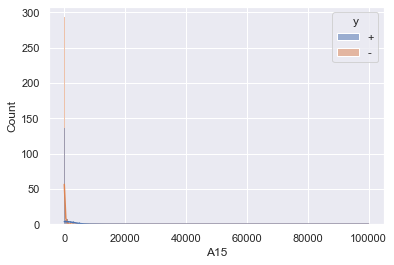

In [8]:
for i in num_cols:
    sns.histplot(data=df,x=i,hue='y',kde=True)
    plt.xlabel(i)
    plt.show()

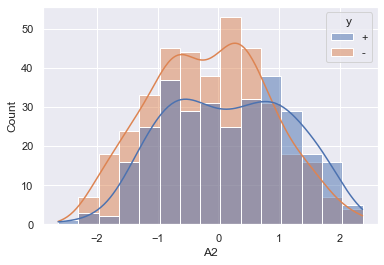

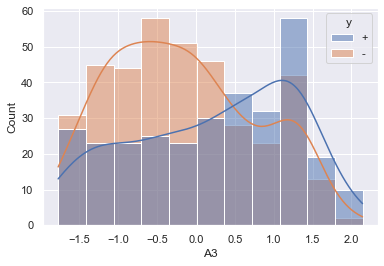

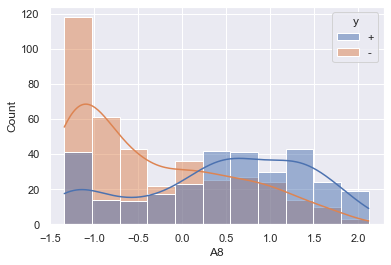

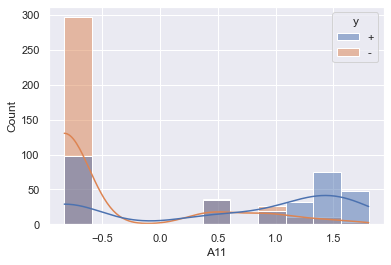

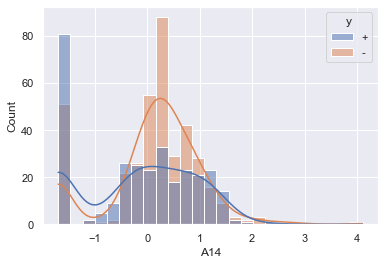

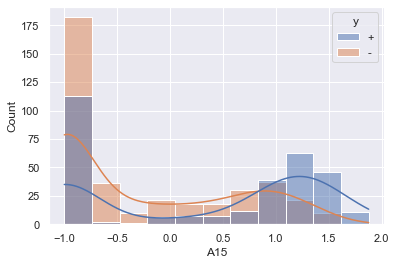

In [9]:
#highly skewed data. Lets try power transform and see how it looks

df2 = df
from sklearn.preprocessing import PowerTransformer
t = PowerTransformer()
t.fit(df2[num_cols])
df2[num_cols] = t.transform(df2[num_cols])
for i in num_cols:
    sns.histplot(data=df2,x=i,hue='y',kde=True)
    plt.xlabel(i)
    plt.show()
#NOT BAD

Definitely better

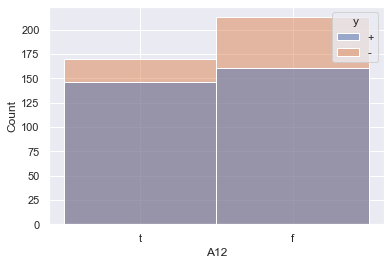

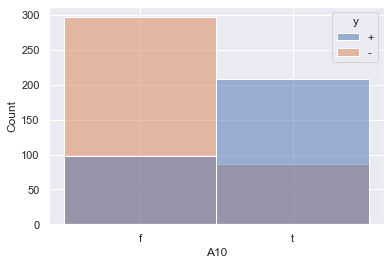

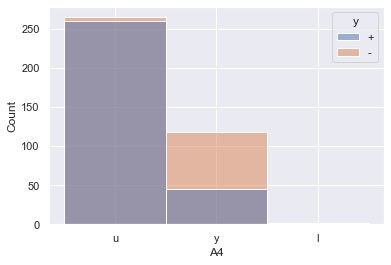

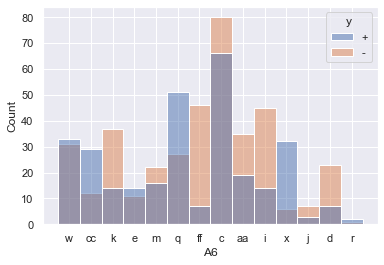

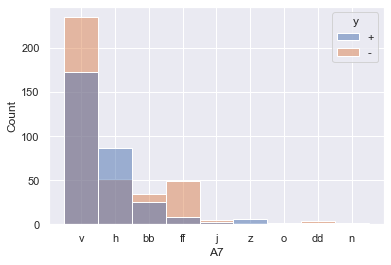

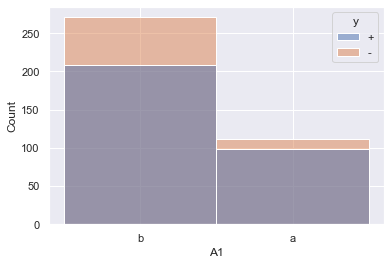

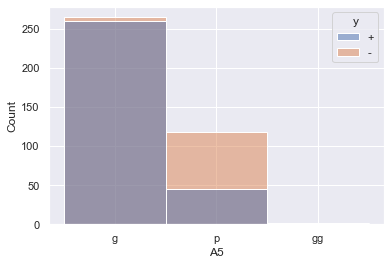

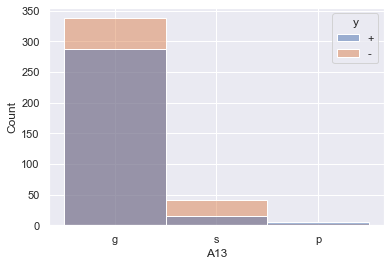

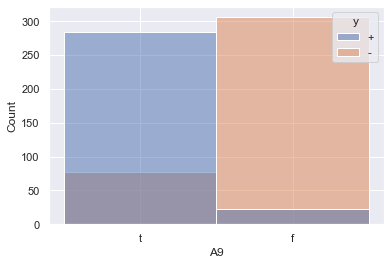

In [10]:
for i in cat_cols:
    sns.histplot(data=df,x=i,hue='y')
    plt.xlabel(i)
    plt.show()

We'll use label encoder for all columns. <br>
Due to obfuscation of the categorical variables, we don't know what they mean. Or else, we could have chosen a better way to encode them.

# Model Fitting

We will fit a neural network model.

In [11]:
from sklearn.preprocessing import LabelEncoder
df[cat_cols] = df[cat_cols].apply(LabelEncoder().fit_transform)
df['y'] = df['y'].replace({'+':1,'-':0})

In [12]:
from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(df.drop('y',axis=1),df['y'],test_size=0.2,random_state=2)

In [13]:
from sklearn.preprocessing import MinMaxScaler #for label encoded columns

power = PowerTransformer()
power.fit(trainX[num_cols])

scaler = MinMaxScaler()
scaler.fit(trainX[cat_cols])

def data_transformer(dfX,y):
    dfX[num_cols] = power.transform(dfX[num_cols])
    dfX[cat_cols] = scaler.transform(dfX[cat_cols])
    
    return dfX.to_numpy(), y.to_numpy().reshape(-1,1)

X_train, y_train = data_transformer(trainX,trainY)
X_test, y_test = data_transformer(testX,testY)

In [14]:
from torch import nn as nn
import torch

In [15]:
Xt_train = torch.from_numpy(X_train).to(torch.float)
Xt_test = torch.from_numpy(X_test).to(torch.float)

yt_train = torch.from_numpy(y_train).to(torch.float)
yt_test = torch.from_numpy(y_test).to(torch.float)

In [16]:
#Building NN
from sklearn.metrics import accuracy_score

class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(nn.Linear(15,50), nn.ReLU(),
                                    nn.Linear(50,10), nn.ReLU(),
                                    nn.Linear(10,1), nn.Sigmoid())
        
    def forward(self,x):
        return self.layers(x)

def train(model, n_epoch, lr, X_train, y_train):
    
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    printstep = int(n_epoch/10)
    
    epoch_loss = list()
    
    for epoch in range(1,n_epoch+1):
        
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss = criterion(y_pred_train,y_train)
        loss.backward()
        optimizer.step()
        epoch_loss.append(loss.item())
        
        if(epoch%printstep == 0):
            print("Epoch {}, Loss {}".format(epoch,loss.item()))
        
    plt.plot(epoch_loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    return model

def model_prediction(X):
    y = model(X).detach().numpy()
    y[y>=0.5] = 1
    y[y<0.5] = 0
    return y

def model_accuracy(X,y):
    y_pred = model_prediction(X)
    return accuracy_score(y,y_pred)

Epoch 25, Loss 0.645847499370575
Epoch 50, Loss 0.5532416701316833
Epoch 75, Loss 0.47107619047164917
Epoch 100, Loss 0.41429635882377625
Epoch 125, Loss 0.36294135451316833
Epoch 150, Loss 0.3247013986110687
Epoch 175, Loss 0.30013829469680786
Epoch 200, Loss 0.2844952940940857
Epoch 225, Loss 0.2716006636619568
Epoch 250, Loss 0.2588237226009369


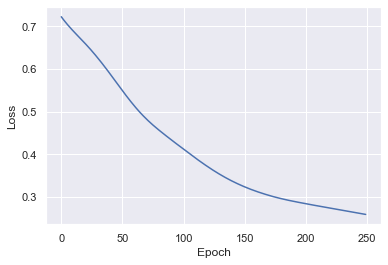

Test Set Accuracy: 0.8840579710144928
Training Set Accuracy: 0.9003623188405797


In [20]:
n_epoch = 250
lr = 0.001

model = NN()
model = train(model,n_epoch,lr,Xt_train,yt_train)

print("Test Set Accuracy: %s"%model_accuracy(Xt_test,yt_test))
print("Training Set Accuracy: %s"%model_accuracy(Xt_train,yt_train))

We get a decent model performance without any regularization (early stopping, etc.)